In [12]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from prophet import Prophet

import datetime
import os

sns.set(style='darkgrid')

In [222]:
os.getcwd()

'/Users/gurdeep/Documents/tb2/DSMP/G32-Butterfly-Data/notebooks/modelling'

In [26]:
dataset_filepath = "/Users/gurdeep/Documents/tb2/DSMP/data/year_merged.csv"

In [27]:
df = pd.read_csv(dataset_filepath)

In [28]:
df['year'].agg(['min', 'max'])

min    2014
max    2020
Name: year, dtype: int64

## Meaning of columns
Meaning of columns/features based on their preffixes:<br>
* 1 - Avg of hourly flow of traffic / year
* 2 - Avg of no2_diff concentration / per year (target)
* 3 - Avg of annual flow of vehicles / year 
* 4 - Avg of sorn vehicle quarterly count of vehicles / year
* 5 - Avg of hourly pollutants / year (target)
* 6 - Avg of 30 mins of weather data / year
* 7 - Avg of licensed vehicle count / year

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 55 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   year                                 7 non-null      int64  
 1   1_pedal_cycles_mean                  7 non-null      float64
 2   1_two_wheeled_motor_vehicles_mean    7 non-null      float64
 3   1_cars_and_taxis_mean                7 non-null      float64
 4   1_buses_and_coaches_mean             7 non-null      float64
 5   1_lgvs_mean                          7 non-null      float64
 6   1_hgvs_2_rigid_axle_mean             7 non-null      float64
 7   1_hgvs_3_rigid_axle_mean             7 non-null      float64
 8   1_hgvs_4_or_more_rigid_axle_mean     7 non-null      float64
 9   1_hgvs_3_or_4_articulated_axle_mean  7 non-null      float64
 10  1_hgvs_5_articulated_axle_mean       7 non-null      float64
 11  1_hgvs_6_articulated_axle_mean      

In [227]:
df.head()

,year,1_pedal_cycles_mean,1_two_wheeled_motor_vehicles_mean,1_cars_and_taxis_mean,1_buses_and_coaches_mean,1_lgvs_mean,1_hgvs_2_rigid_axle_mean,1_hgvs_3_rigid_axle_mean,1_hgvs_4_or_more_rigid_axle_mean,1_hgvs_3_or_4_articulated_axle_mean,1_hgvs_5_articulated_axle_mean,1_hgvs_6_articulated_axle_mean,1_all_hgvs_mean,1_all_motor_vehicles_mean,2_no2_diff_conc_mean,3_pedal_cycles_mean,3_two_wheeled_motor_vehicles_mean,3_cars_and_taxis_mean,3_buses_and_coaches_mean,3_lgvs_mean,3_hgvs_2_rigid_axle_mean,3_hgvs_3_rigid_axle_mean,3_hgvs_4_or_more_rigid_axle_mean,3_hgvs_3_or_4_articulated_axle_mean,3_hgvs_5_articulated_axle_mean,3_hgvs_6_articulated_axle_mean,3_all_hgvs_mean,3_all_motor_vehicles_mean,4_cars_mean,4_motorcycles_mean,4_others_mean,5_nox_mean,5_no2_mean,5_no_mean,5_vpm10_mean,5_vpm25_mean,5_co_mean,5_o3_mean,5_so2_mean,6_dewpoint_tempt_mean,6_wind_speed_mean,6_wind_dir_mean,6_atm_pressure_mean,6_visibility_mean,6_wind_chill_tempt_mean,6_relative_humidity_mean,7_cars_mean,7_motorcycles_mean,7_light_goods_vehicles_mean,7_heavy_goods_vehicles_mean,7_buses_and_coaches_mean,7_other_vehicles_mean,7_total_mean,7_diesel_cars_mean,7_diesel_vans_mean
0,2014,7.250868,7.974826,434.249132,8.538194,82.284722,11.623264,2.437500,2.979167,1.031250,3.472222,6.115451,27.658854,560.705729,41.026698,277.598540,273.788321,15567.591241,325.372263,2787.029197,329.218978,77.948905,78.343066,33.167883,138.306569,177.795620,834.766423,19788.474453,494.652158,229.968088,158.306799,80.706936,37.236936,28.362941,3.227802,3.408625,0.0,44.090304,0.0,7.939865,4.752059,185.047080,1011.776632,8.789232,9.157295,84.165388,244431.0,8439.0,37378.0,5913.0,2661.0,2871.0,301693.0,103991.0,36219.0
1,2015,6.962862,5.706522,352.923007,6.870471,60.564312,7.809783,1.396739,1.509964,0.957428,1.942029,4.003623,17.619565,443.683877,41.153084,274.189781,268.189781,15595.978102,325.678832,2893.649635,335.386861,79.678832,76.737226,40.839416,136.233577,189.912409,858.766423,19942.189781,580.771895,257.637125,184.552861,77.834705,36.342069,26.874141,3.045969,2.980039,0.0,44.508744,0.0,7.170237,5.144535,192.222414,1016.564152,8.853867,8.651502,82.641452,255691.0,8633.0,40874.0,6427.0,2769.0,2962.0,317356.0,112040.0,39750.0
2,2016,11.112007,5.584229,273.189068,7.345878,51.405018,4.904122,1.096774,1.175627,0.383513,1.013441,0.950717,9.524194,347.048387,42.069074,286.423358,266.299270,15890.364964,305.518248,3082.467153,339.372263,77.554745,87.167883,42.963504,133.802920,193.737226,874.554745,20419.277372,698.710813,287.654962,218.024048,87.079133,37.095834,32.603087,2.978796,3.289537,0.0,38.836987,0.0,7.375927,4.724064,188.449652,1015.422514,8.953324,8.445196,84.221693,265359.0,8912.0,44403.0,6285.0,2767.0,3044.0,330770.0,119457.0,43290.0
3,2017,11.794818,9.904062,561.876050,10.351541,105.087535,12.231793,2.333333,3.068627,0.817927,2.957983,4.535714,25.945378,713.164566,40.081132,301.079137,266.007194,15766.223022,291.122302,3030.021583,344.424460,76.942446,94.661871,35.381295,147.366906,198.230216,897.035971,20250.438849,787.506004,319.023843,251.944396,76.952563,34.814835,27.478863,4.966673,2.576377,0.0,44.761449,0.0,8.060080,4.788803,208.922330,1015.986514,8.840114,8.991153,86.117015,181503.0,8901.0,26888.0,5702.0,3491.0,2821.0,229306.0,61065.0,25846.0
4,2018,11.575540,4.967626,224.259592,7.423261,46.091727,5.495803,1.214628,1.685851,0.451439,1.257794,3.068945,13.174460,295.916667,36.545984,336.044586,236.949045,13933.573248,244.872611,2600.382166,299.063694,65.146497,81.777070,28.694268,100.254777,210.267516,785.101911,17800.796178,842.598435,344.072316,280.708996,74.723108,35.214590,25.761044,19.541392,12.037916,0.0,50.792987,0.0,8.011392,4.866568,180.164300,1014.330983,8.880500,8.828363,85.898428,182282.0,8800.0,27273.0,2503.0,3267.0,2535.0,226660.0,61785.0,26244.0


In [228]:
targets = [col for col in df.columns if col.startswith("2") or col.startswith("5")]
features = [col for col in df.columns if not (col.startswith("2") or col.startswith("5")) and col != 'year']

print("Potential Targets:", len(targets))
print("Features:", len(features))

Potential Targets: 9
Features: 45


# Annual Dataset

## Forecasting NO2 yearly data from diff tubes

<AxesSubplot:>

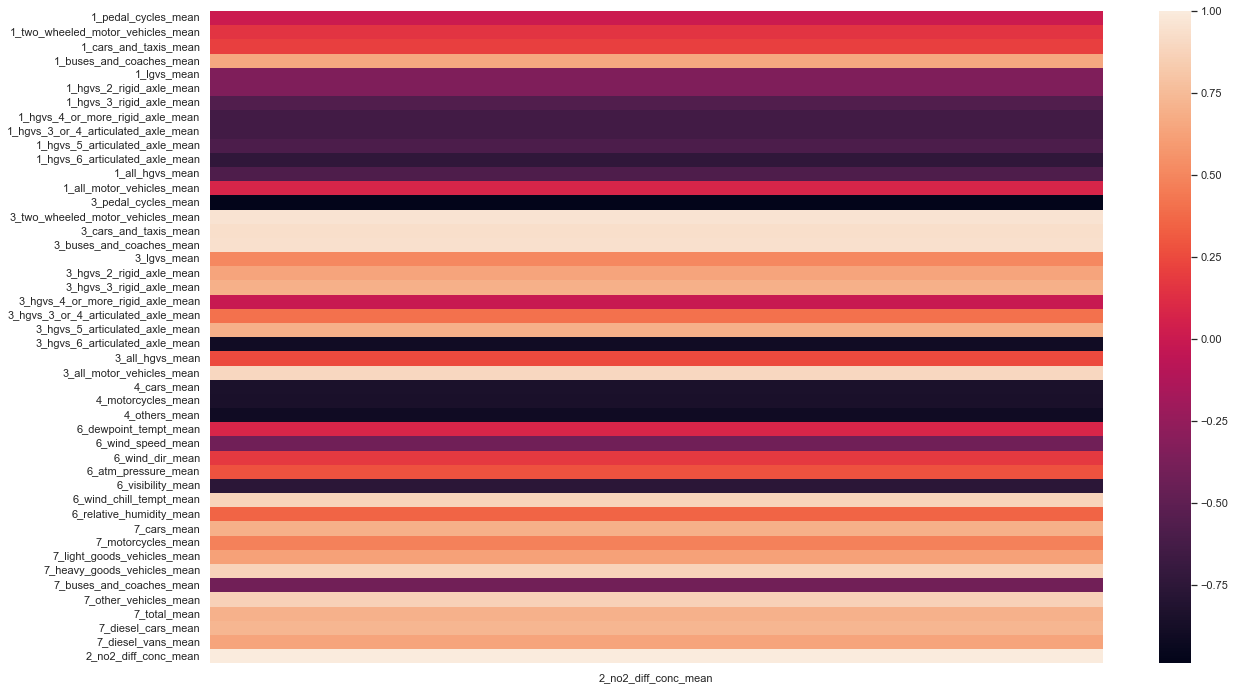

In [15]:
plt.figure(figsize=(20, 12))
sns.heatmap(df[features+['2_no2_diff_conc_mean']].corr().loc[:, '2_no2_diff_conc_mean'].to_frame())

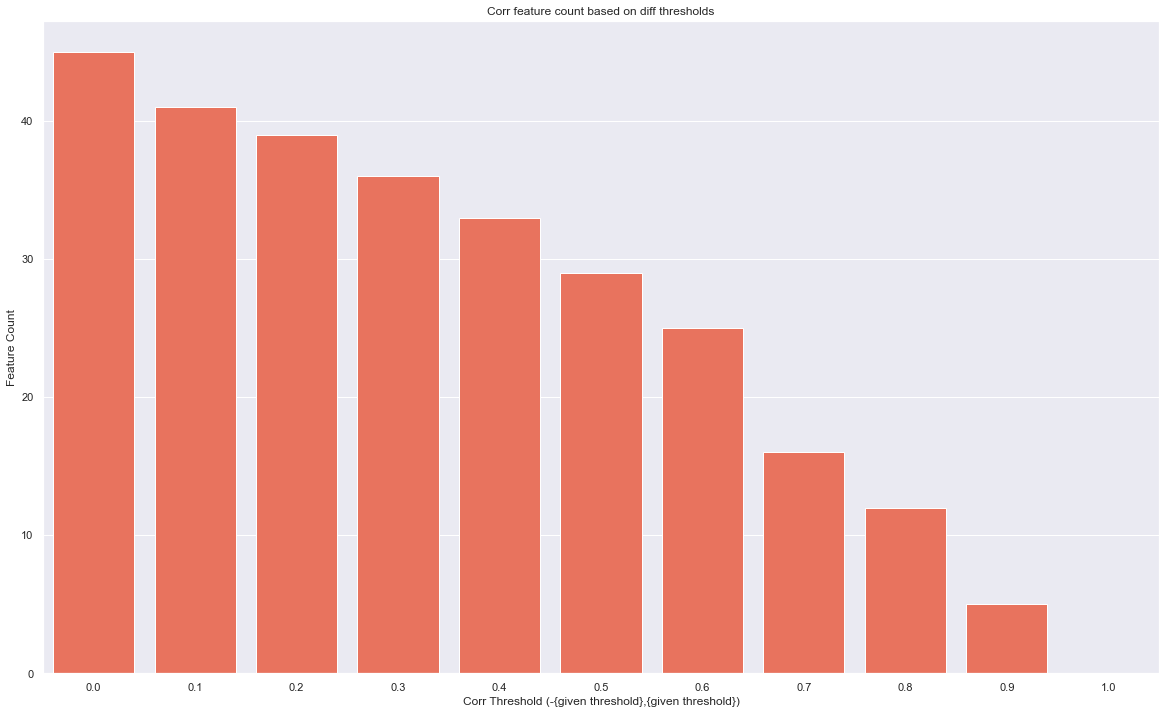

In [16]:
# extracting highly corr features with the target variable
def corr_feature_extractor(df: pd.DataFrame, target: str, threshold: float) -> list:
    temp_df = df.corr().loc[:, target].to_frame()
    features = temp_df[~temp_df[target].between(-threshold, threshold)].index.tolist()
    return list(filter(lambda x: x!=target, features))


def corr_features_cv(df, target):
    x, y = [], []
    for i in np.arange(0.0, 1.1, 0.1):
        x.append(round(i, 1))
        y.append(len(corr_feature_extractor(df, target, i)))
    
    plt.figure(figsize=(20, 12))
    sns.barplot(x=x, y=y, color='tomato')
    plt.title("Corr feature count based on diff thresholds")
    plt.xlabel("Corr Threshold (-{given threshold},{given threshold})")
    plt.ylabel("Feature Count")
    plt.show()

corr_features_cv(df[features+['2_no2_diff_conc_mean']], '2_no2_diff_conc_mean')

No of selected features based on 0.5 threshold: 29


<AxesSubplot:>

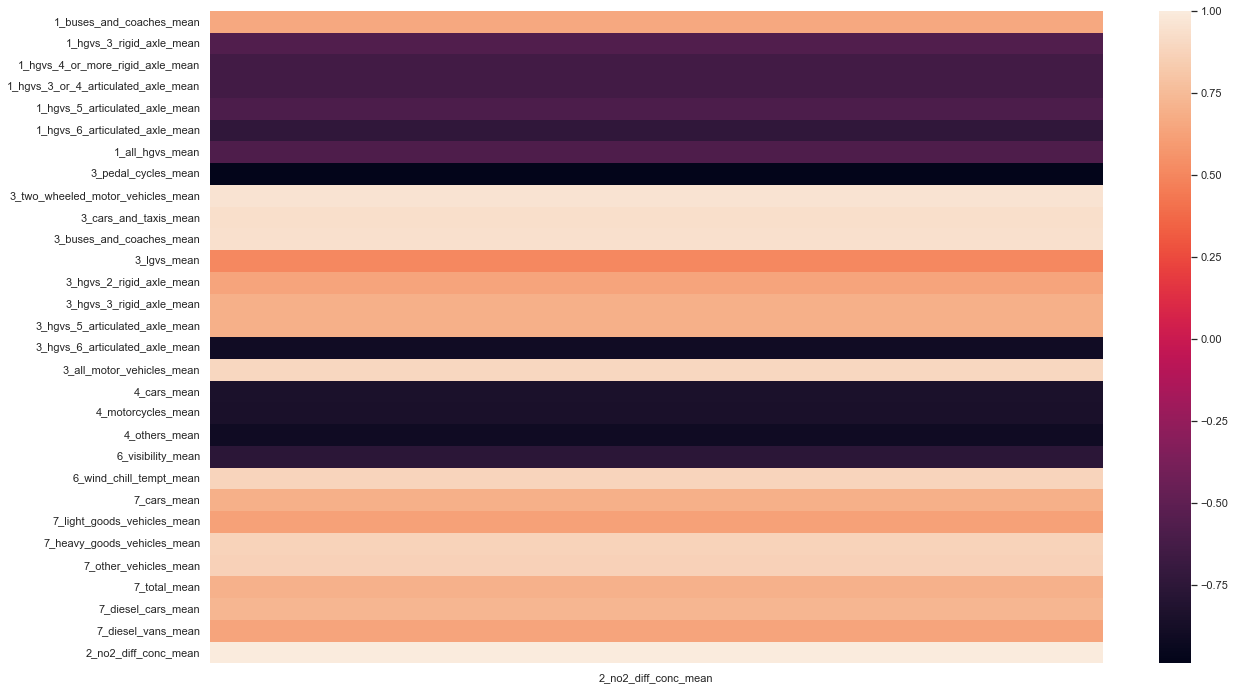

In [17]:
corr_50_features = corr_feature_extractor(df[features+['2_no2_diff_conc_mean']], '2_no2_diff_conc_mean', 0.5)
print("No of selected features based on 0.5 threshold:", len(corr_50_features))
plt.figure(figsize=(20, 12))
sns.heatmap(df[corr_50_features+['2_no2_diff_conc_mean']].corr().loc[:, '2_no2_diff_conc_mean'].to_frame())

In [18]:
df[corr_50_features[:1]+['2_no2_diff_conc_mean']]

,1_buses_and_coaches_mean,2_no2_diff_conc_mean
0,8.538194,41.026698
1,6.870471,41.153084
2,7.345878,42.069074
3,10.351541,40.081132
4,7.423261,36.545984
5,5.309055,35.534216
6,5.139194,28.291544


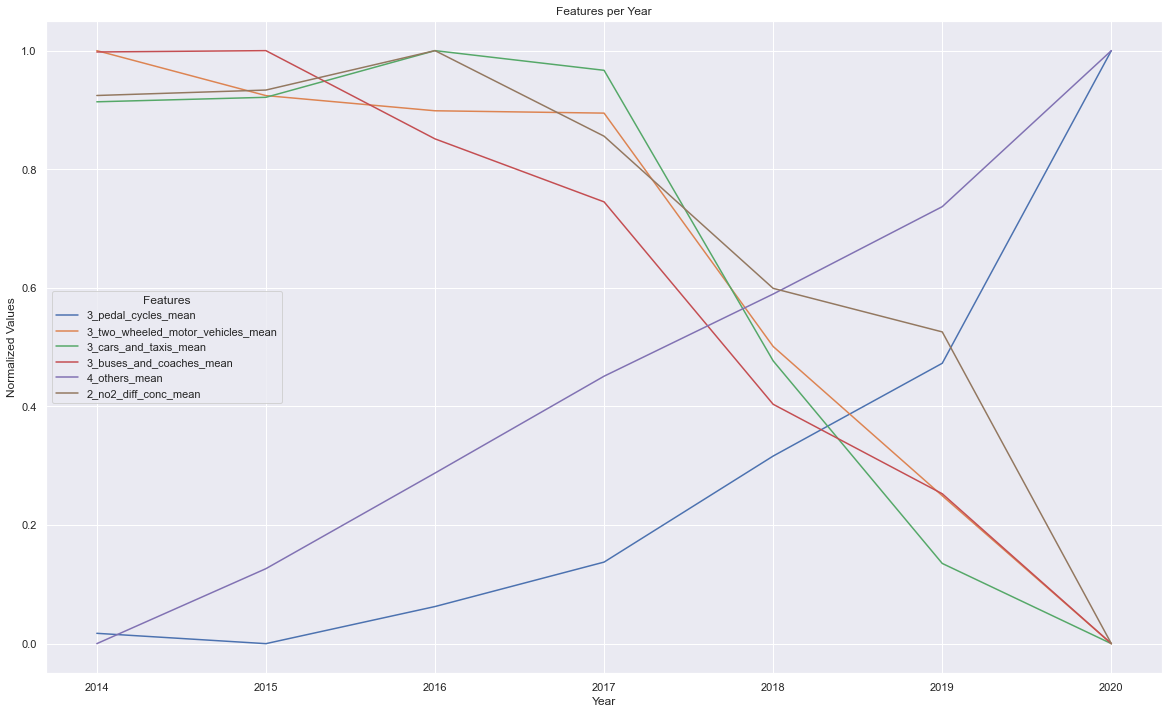

In [19]:
def plot_features(df, x: str, y_list: list):
    plt.figure(figsize=(20, 12))
    for f in y_list:
        sns.lineplot(x=x, y=f, data=df)
    plt.title("Features per " + x.title())
    plt.xlabel(x.title())
    plt.ylabel("Normalized Values")
    plt.legend(y_list, title="Features")
    plt.show()

scaler = MinMaxScaler((0,1))

scaled_df = pd.concat([pd.DataFrame(scaler.fit_transform(df[corr_50_features+['2_no2_diff_conc_mean']]), 
                        columns=scaler.get_feature_names_out()), 
                       df[['year']]], axis=1)

# for threshold 0.9
plot_features(scaled_df, 'year', corr_feature_extractor(df[features+['2_no2_diff_conc_mean']], '2_no2_diff_conc_mean', 0.9) + ['2_no2_diff_conc_mean'])

In [20]:
# pd.DataFrame({'cat':pd.Series(df[corr_50_features].columns).apply(lambda x: x.split("_")[0]).astype(int).tolist()}
#               '')

In [125]:
df[corr_50_features]'2_no2_diff_conc_mean'

,1_buses_and_coaches_mean,1_hgvs_3_rigid_axle_mean,1_hgvs_4_or_more_rigid_axle_mean,1_hgvs_3_or_4_articulated_axle_mean,1_hgvs_5_articulated_axle_mean,1_hgvs_6_articulated_axle_mean,1_all_hgvs_mean,3_pedal_cycles_mean,3_two_wheeled_motor_vehicles_mean,3_cars_and_taxis_mean,...,4_others_mean,6_visibility_mean,6_wind_chill_tempt_mean,7_cars_mean,7_light_goods_vehicles_mean,7_heavy_goods_vehicles_mean,7_other_vehicles_mean,7_total_mean,7_diesel_cars_mean,7_diesel_vans_mean
0,8.538194,2.437500,2.979167,1.031250,3.472222,6.115451,27.658854,277.598540,273.788321,15567.591241,...,158.306799,8.789232,9.157295,244431.0,37378.0,5913.0,2871.0,301693.0,103991.0,36219.0
1,6.870471,1.396739,1.509964,0.957428,1.942029,4.003623,17.619565,274.189781,268.189781,15595.978102,...,184.552861,8.853867,8.651502,255691.0,40874.0,6427.0,2962.0,317356.0,112040.0,39750.0
2,7.345878,1.096774,1.175627,0.383513,1.013441,0.950717,9.524194,286.423358,266.299270,15890.364964,...,218.024048,8.953324,8.445196,265359.0,44403.0,6285.0,3044.0,330770.0,119457.0,43290.0
3,10.351541,2.333333,3.068627,0.817927,2.957983,4.535714,25.945378,301.079137,266.007194,15766.223022,...,251.944396,8.840114,8.991153,181503.0,26888.0,5702.0,2821.0,229306.0,61065.0,25846.0
4,7.423261,1.214628,1.685851,0.451439,1.257794,3.068945,13.174460,336.044586,236.949045,13933.573248,...,280.708996,8.880500,8.828363,182282.0,27273.0,2503.0,2535.0,226660.0,61785.0,26244.0
5,5.309055,1.687664,2.281496,0.853018,3.508530,4.907480,21.100394,366.636364,218.363636,12655.863636,...,311.302103,9.129507,7.606256,183188.0,27988.0,2013.0,2414.0,227607.0,60995.0,26809.0
6,5.139194,3.062271,4.048535,1.554945,4.239011,9.256410,34.753663,469.716535,199.944882,12149.984252,...,365.926692,9.123082,-8.052975,182186.0,28723.0,1894.0,2436.0,226776.0,57618.0,27412.0


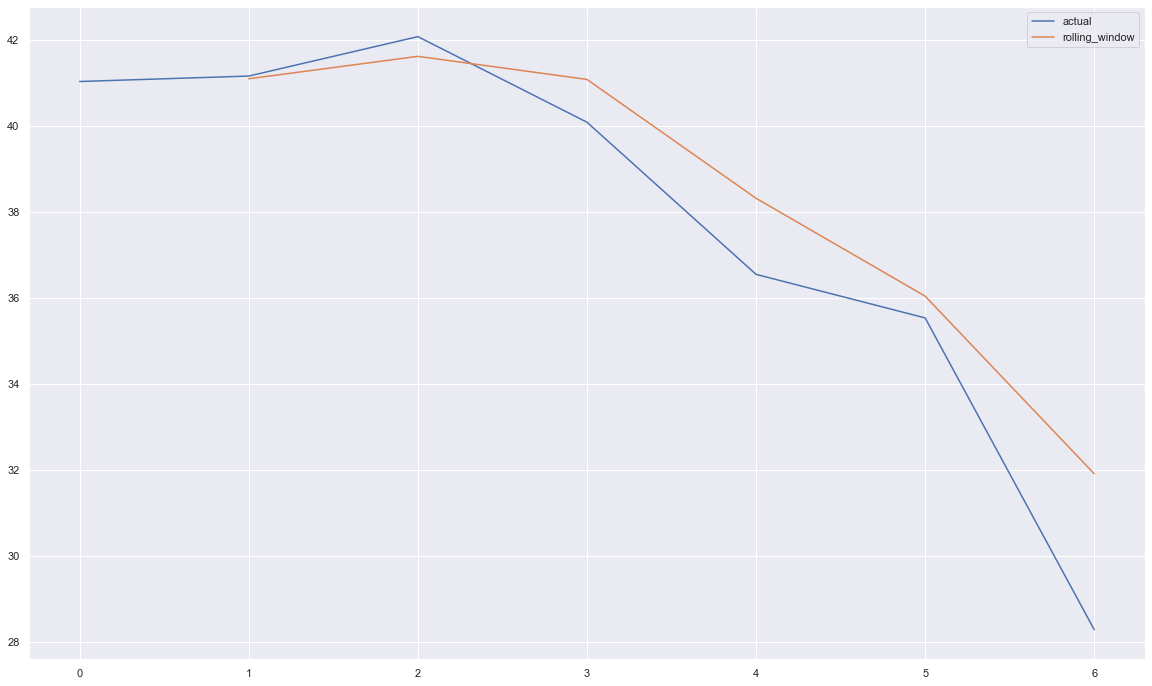

In [207]:
plt.figure(figsize=(20, 12))
df['2_no2_diff_conc_mean'].plot()
df['2_no2_diff_conc_mean'].rolling(window=2).mean().dropna().plot()
plt.legend(['actual', 'rolling_window'])

Feature Count: 2
Features: ['3_pedal_cycles_mean', '3_two_wheeled_motor_vehicles_mean']


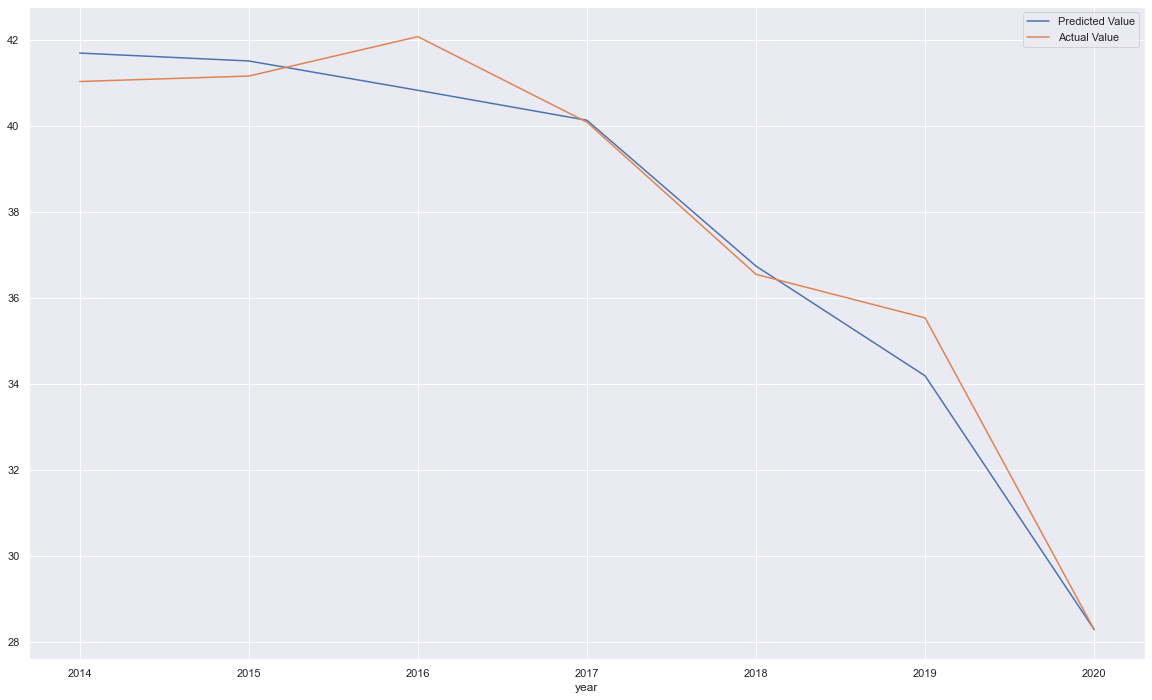

In [216]:
train_set_year_threshold = 2019
lr_model_features = corr_feature_extractor(df[features+['2_no2_diff_conc_mean']], '2_no2_diff_conc_mean', 0.95)
print("Feature Count:", len(lr_model_features))
print("Features:", lr_model_features)

df.sort_values(by='year', inplace=True)
df.reset_index(drop=True, inplace=True)
model1 = LinearRegression()
model1.fit(df[df['year'] < train_set_year_threshold][lr_model_features], df[df['year'] < train_set_year_threshold]['2_no2_diff_conc_mean'])
train_pred = model1.predict(df[df['year'] < train_set_year_threshold][lr_model_features])
test_pred = model1.predict(df[df['year'] >= train_set_year_threshold][lr_model_features])

plt.figure(figsize=(20, 12))
sns.lineplot(x=df['year'], y=model1.predict(df[lr_model_features]))
sns.lineplot(x=df['year'], y=df['2_no2_diff_conc_mean'].tolist())
plt.legend(["Predicted Value", "Actual Value"])
# list(zip(model1.coef_, corr_50_features))

In [46]:
df['datetime'] = pd.to_datetime(df['year'], format="%Y")

In [47]:
corr_92_features = corr_feature_extractor(df[features+['2_no2_diff_conc_mean']], '2_no2_diff_conc_mean', 0.92)
corr_92_features

['3_pedal_cycles_mean',
 '3_two_wheeled_motor_vehicles_mean',
 '3_cars_and_taxis_mean',
 '3_buses_and_coaches_mean']

In [62]:
df['year']

0    2014
1    2015
2    2016
3    2017
4    2018
5    2019
6    2020
Name: year, dtype: int64

In [64]:
pd.DataFrame({'ds':range(2021, 2026)})

,ds
0,2021
1,2022
2,2023
3,2024
4,2025


## Forecasted Annual NO2 Trend

In [30]:
ndf = pd.read_csv("/Users/gurdeep/Documents/tb2/DSMP/data/air_quality_no2_diffusion_data.csv", delimiter=';')
ndf.head()

,Site ID,Location,Year,Concentration ugm-3,Count,Easting,Northing,geo_point_2d
0,577,High St lamp post outside Wards solicitors,2020,30.470961,6,358935,172981,"51.4543108936,-2.59239070501"
1,576,"Baldwin Street lamp post by cycle way, opp St ...",2020,23.947466,6,358792,172874,"51.4533384314,-2.59443611661"
2,575,Baldwin Street traffic light outside domino's,2020,30.898421,7,358685,172881,"51.4533935487,-2.59597673968"
3,574,"Whiteladies road, on loading sign next to Redl...",2020,27.257356,8,357678,174229,"51.4654388504,-2.61062992462"
4,571,Muller road junction with Downend road traffic...,2019,42.830000,5,359848,176411,"51.4852158694,-2.57964253646"


In [31]:
ndf['Concentration ugm-3'].describe()

count    1244.000000
mean       40.702128
std        12.552947
min        14.910000
25%        32.580000
50%        39.225000
75%        47.972500
max       102.550000
Name: Concentration ugm-3, dtype: float64

In [32]:
def outliers(df, multiplier=1.5):
    stats = df['Concentration ugm-3'].describe()
    iqr = (stats['75%'] * stats['25%']) * multiplier
    return df['Concentration ugm-3'][~df['Concentration ugm-3'].between(stats['25%'] - iqr, stats['75%'] + iqr)]

sites = ndf.groupby('Site ID')['Year'].count()[(ndf.groupby('Site ID')['Year'].count() == 11)].reset_index()['Site ID'].tolist()
ndf = ndf[ndf['Site ID'].isin(sites)]
ndf['year'] = ndf['Year']
ndf['no2_conc'] = ndf['Concentration ugm-3']
ndf

,Site ID,Location,Year,Concentration ugm-3,Count,Easting,Northing,geo_point_2d,year,no2_conc
211,478,T shirt Shop W. Town Lane,2019,28.80,12,362091,170447,"51.4317481123,-2.5467001823",2019,28.80
212,478,T shirt Shop W. Town Lane,2018,36.46,12,362091,170447,"51.4317481123,-2.5467001823",2018,36.46
213,478,T shirt Shop W. Town Lane,2017,35.35,12,362091,170447,"51.4317481123,-2.5467001823",2017,35.35
214,478,T shirt Shop W. Town Lane,2013,39.89,12,362091,170447,"51.4317481123,-2.5467001823",2013,39.89
215,478,T shirt Shop W. Town Lane,2016,36.68,12,362091,170447,"51.4317481123,-2.5467001823",2016,36.68
...,...,...,...,...,...,...,...,...,...,...
1239,2,Colston Avenue,2016,66.11,11,358628,173011,"51.4545582107,-2.59681225748",2016,66.11
1240,2,Colston Avenue,2019,53.71,11,358628,173011,"51.4545582107,-2.59681225748",2019,53.71
1241,2,Colston Avenue,2011,78.81,12,358628,173011,"51.4545582107,-2.59681225748",2011,78.81
1242,2,Colston Avenue,2012,66.82,12,358628,173011,"51.4545582107,-2.59681225748",2012,66.82


<AxesSubplot:xlabel='Year', ylabel='Concentration ugm-3'>

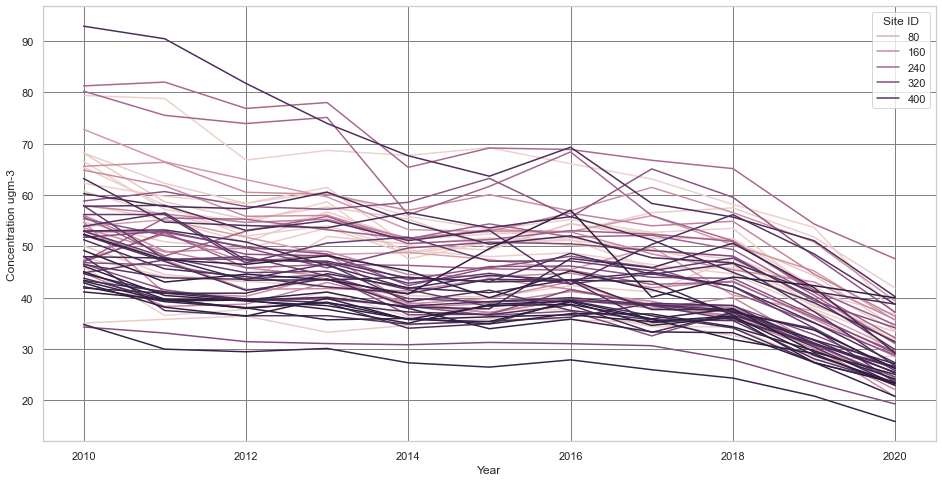

In [33]:
plt.figure(figsize=(16, 8))
sns.lineplot(x='Year', y='Concentration ugm-3', hue='Site ID', data=ndf)

In [34]:
ndf.groupby("year")['no2_conc'].mean().reset_index()

,year,no2_conc
0,2010,53.996094
1,2011,50.718125
2,2012,48.193906
3,2013,48.797344
4,2014,44.982031
5,2015,45.402656
6,2016,46.440312
7,2017,44.316563
8,2018,43.243906
9,2019,36.613750


In [38]:
def forecast(df, date_col, target_col, periods=5):
    train_data=df[[date_col, target_col]].rename(columns={date_col:'ds',target_col:'y'})
    model = Prophet()
    model.fit(train_data)
    pred = model.predict(pd.DataFrame({'ds':range(train_data['ds'].min(), 
                                                  train_data['ds'].max()+periods+1)}))
    pred['year'] = pred['ds'].dt.year
    return pred

# forecasted = forecast(df[['year', '2_no2_diff_conc_mean']].rename(columns={'year':'ds', '2_no2_diff_conc_mean':'y'}),
#                       4)
forecasted = forecast(ndf.groupby("year")['no2_conc'].mean().reset_index(), 
                      'year', 
                      'no2_conc', 6)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/gurdeep/opt/anaconda3/envs/dsmp/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:n_changepoints greater than number of observations. Using 7.
/Users/gurdeep/opt/anaconda3/envs/dsmp/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/gurdeep/opt/anaconda3/envs/dsmp/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

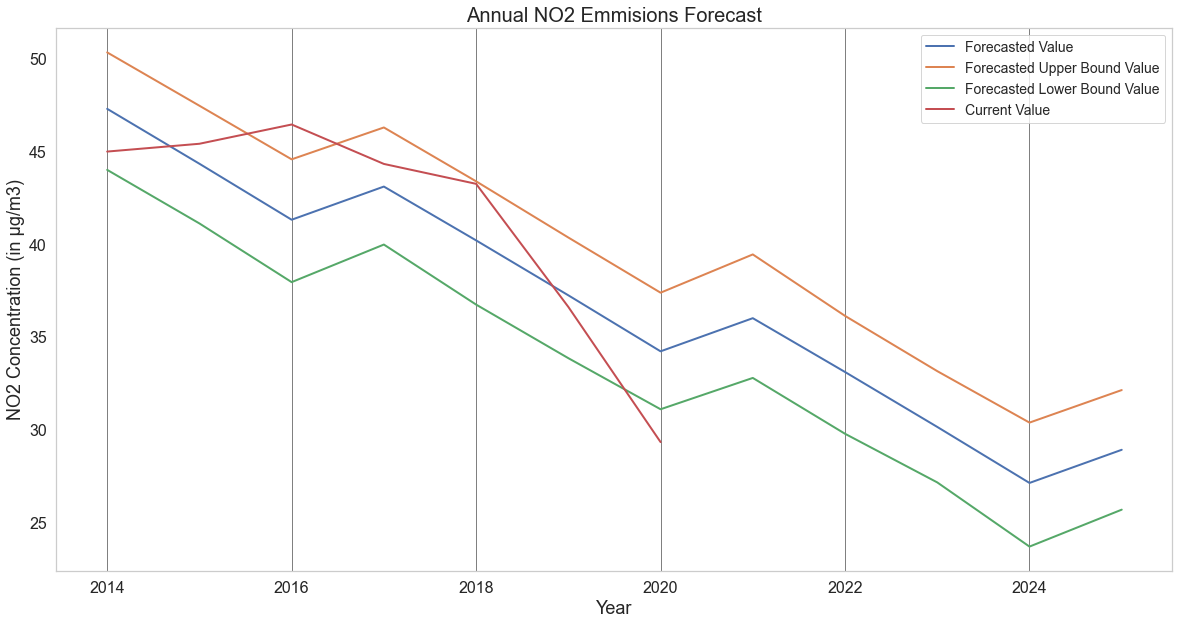

In [39]:
plot_data = ndf.groupby("year")['no2_conc'].mean().reset_index()

plt.figure(figsize=(20, 10))
sns.lineplot(x='year', y='yhat', data=forecasted[forecasted['year'].between(2014, 2025)], linewidth=2)
sns.lineplot(x='year', y='yhat_upper', data=forecasted[forecasted['year'].between(2014, 2025)], linewidth=2)
sns.lineplot(x='year', y='yhat_lower', data=forecasted[forecasted['year'].between(2014, 2025)], linewidth=2)
sns.lineplot(x='year', y='no2_conc', data=plot_data[plot_data['year'].between(2014, 2025)], linewidth=2)

plt.title("Annual NO2 Emmisions Forecast", fontsize=20)
plt.legend(["Forecasted Value", "Forecasted Upper Bound Value", "Forecasted Lower Bound Value", "Current Value"], fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Year", fontsize=18)
plt.grid(False, axis='y')
mpl.rcParams['grid.color'] = 'grey'
plt.ylabel("NO2 Concentration (in µg/m3)", fontsize=18)
plt.show()

In [465]:
data = forecasted[['year', 'yhat']].merge(plot_data[['year', 'no2_conc']], on='year', how='left')
data['y'] = data['no2_conc'].fillna(data['yhat'])
data['y_next'] = data['y'].shift(-1)
data['y_diff'] = (data['y_next'] - data['y'])
data['y_chng'] = data['y_diff']/data['y']*100

print("Average change in concentration per year from 2014 to 2020:", np.round(data[data['year'].between(2014, 2020)]['y_diff'].mean(), 2), "ug/m3 per year")
print("Average change in concentration per year from 2014 to 2020:", np.round(data[data['year'].between(2014, 2020)]['y_chng'].mean(), 2), "%\n pear year")

print("Average change in concentration per year from 2021 to 2025:", np.round(data[data['year'].between(2021, 2025)]['y_diff'].mean(), 2), "ug/m3 per year")
print("Average change in concentration per year from 2021 to 2025:", np.round(data[data['year'].between(2021, 2025)]['y_chng'].mean(), 2), "%\n per year")

print("Average change in concentration from 2020 to 2025:", np.round(data[data['year'] == 2025]['y'].iloc[0] - data[data['year'] == 2020]['y'].iloc[0], 2), "ug/m3")
print("Average change in concentration from 2020 to 2025:", np.round((data[data['year'] == 2025]['y'].iloc[0] - data[data['year'] == 2020]['y'].iloc[0])/data[data['year'] == 2020]['y'].iloc[0]*100, 2), "%")
data

Average change in concentration per year from 2014 to 2020: -1.28 ug/m3 per year
Average change in concentration per year from 2014 to 2020: -2.32 %
 pear year
Average change in concentration per year from 2021 to 2025: -2.0 ug/m3 per year
Average change in concentration per year from 2021 to 2025: -6.09 %
 per year
Average change in concentration from 2020 to 2025: -0.42 ug/m3
Average change in concentration from 2020 to 2025: -1.42 %


,year,yhat,no2_conc,y,y_next,y_diff,y_chng
0,2010,54.370163,53.996094,53.996094,50.718125,-3.277969,-6.070752
1,2011,51.412240,50.718125,50.718125,48.193906,-2.524219,-4.976956
2,2012,48.395863,48.193906,48.193906,48.797344,0.603438,1.252103
3,2013,50.182457,48.797344,48.797344,44.982031,-3.815313,-7.818689
4,2014,47.284441,44.982031,44.982031,45.402656,0.420625,0.935096
5,2015,44.326518,45.402656,45.402656,46.440312,1.037656,2.285453
6,2016,41.310141,46.440312,46.440312,44.316563,-2.123750,-4.573074
7,2017,43.096735,44.316563,44.316563,43.243906,-1.072656,-2.420441
8,2018,40.197683,43.243906,43.243906,36.613750,-6.630156,-15.332001
9,2019,37.238723,36.613750,36.613750,29.333345,-7.280405,-19.884346


# Forecasted Annual Vehicle Trend

In [40]:
forecasted = forecast(df, 'year', '3_all_motor_vehicles_mean')

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/gurdeep/opt/anaconda3/envs/dsmp/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:n_changepoints greater than number of observations. Using 4.
/Users/gurdeep/opt/anaconda3/envs/dsmp/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/gurdeep/opt/anaconda3/envs/dsmp/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

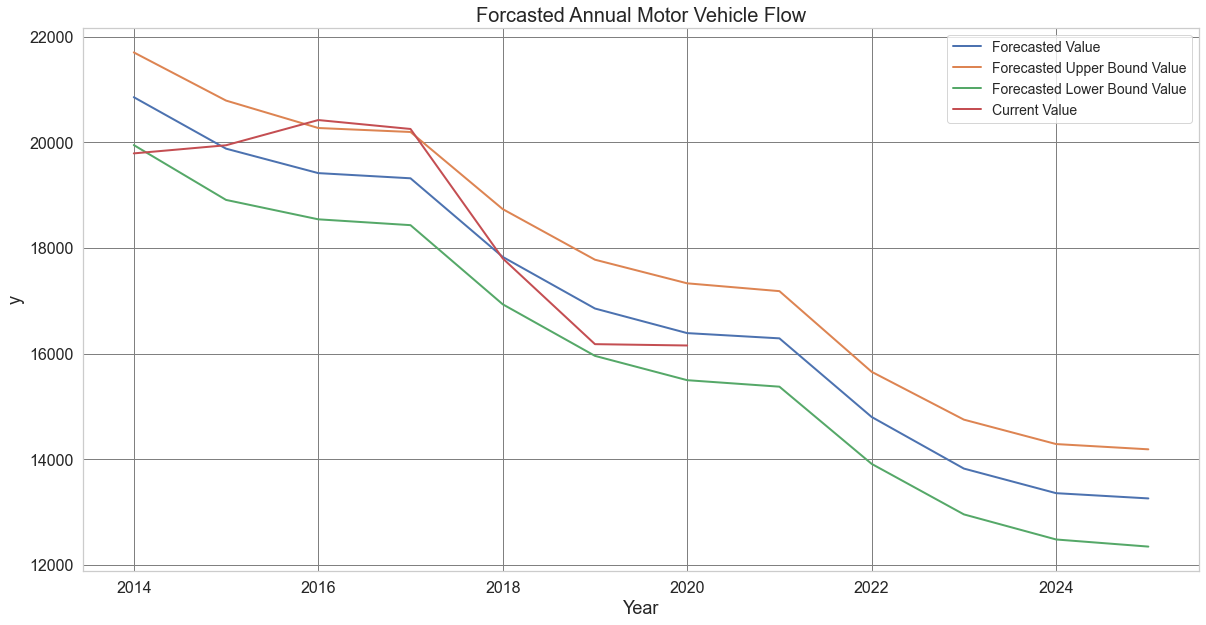

In [42]:
plt.figure(figsize=(20, 10))

sns.lineplot(x='year', y='yhat', data=forecasted[forecasted['year'].between(2014, 2025)], linewidth=2)
sns.lineplot(x='year', y='yhat_upper', data=forecasted[forecasted['year'].between(2014, 2025)], linewidth=2)
sns.lineplot(x='year', y='yhat_lower', data=forecasted[forecasted['year'].between(2014, 2025)], linewidth=2)
sns.lineplot(x='year', y='3_all_motor_vehicles_mean', data=df[df['year'].between(2014, 2025)], linewidth=2)

plt.title("Forcasted Annual Motor Vehicle Flow", fontsize=20)
plt.legend(["Forecasted Value", "Forecasted Upper Bound Value", "Forecasted Lower Bound Value", "Current Value"], fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Year", fontsize=18)
plt.ylabel("N", fontsize=18)
plt.show()

In [357]:
data = forecasted[['year', 'yhat']].merge(df[['year', '3_all_motor_vehicles_mean']], on='year', how='left')
data['y'] = data['3_all_motor_vehicles_mean'].fillna(data['yhat'])
data['y_next'] = data['y'].shift(-1)
data['y_diff'] = (data['y_next'] - data['y'])
data['y_chng'] = data['y_diff']/data['y']*100

print("Average change in vehicle count per year from 2014 to 2020:", np.round(data[data['year'].between(2014, 2020)]['y_diff'].mean(), 2), "")
print("Average change in vehicle count per year from 2014 to 2020:", np.round(data[data['year'].between(2014, 2020)]['y_chng'].mean(), 2), "%\n")

print("Average change in vehicle count per year from 2021 to 2025:", np.round(data[data['year'].between(2021, 2025)]['y_diff'].mean(), 2), "")
print("Average change in vehicle count per year from 2021 to 2025:", np.round(data[data['year'].between(2021, 2025)]['y_chng'].mean(), 2), "%\n")

print("Average change in vehicle count from 2020 to 2025:", np.round(data[data['year'] == 2025]['y'].iloc[0] - data[data['year'] == 2020]['y'].iloc[0], 2), "")
print("Average change in vehicle count from 2020 to 2025:", np.round((data[data['year'] == 2025]['y'].iloc[0] - data[data['year'] == 2020]['y'].iloc[0])/data[data['year'] == 2020]['y'].iloc[0]*100, 2), "%")
data

Average change in vehicle count per year from 2014 to 2020: -500.01 
Average change in vehicle count per year from 2014 to 2020: -2.6 %

Average change in vehicle count per year from 2021 to 2025: -757.18 
Average change in vehicle count per year from 2021 to 2025: -4.96 %

Average change in vehicle count from 2020 to 2025: -2893.68 
Average change in vehicle count from 2020 to 2025: -17.91 %


,year,yhat,3_all_motor_vehicles_mean,y,y_next,y_diff,y_chng
0,2014,20852.020685,19788.474453,19788.474453,19942.189781,153.715328,0.776792
1,2015,19877.948330,19942.189781,19942.189781,20419.277372,477.087591,2.392353
2,2016,19415.117028,20419.277372,20419.277372,20250.438849,-168.838523,-0.826858
3,2017,19317.116477,20250.438849,20250.438849,17800.796178,-2449.642671,-12.096739
4,2018,17829.543539,17800.796178,17800.796178,16178.676136,-1622.120042,-9.112626
5,2019,16852.957227,16178.676136,16178.676136,16153.338583,-25.337554,-0.156611
6,2020,16387.611952,16153.338583,16153.338583,16288.387299,135.048716,0.836042
7,2021,16288.387299,NaN,16288.387299,14800.814366,-1487.572933,-9.132721
8,2022,14800.814366,NaN,14800.814366,13824.228054,-976.586312,-6.598193
9,2023,13824.228054,NaN,13824.228054,13358.882780,-465.345274,-3.366157


# Forecasted Average quarterly count of SORN vehicles 

In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 56 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   year                                 7 non-null      int64         
 1   1_pedal_cycles_mean                  7 non-null      float64       
 2   1_two_wheeled_motor_vehicles_mean    7 non-null      float64       
 3   1_cars_and_taxis_mean                7 non-null      float64       
 4   1_buses_and_coaches_mean             7 non-null      float64       
 5   1_lgvs_mean                          7 non-null      float64       
 6   1_hgvs_2_rigid_axle_mean             7 non-null      float64       
 7   1_hgvs_3_rigid_axle_mean             7 non-null      float64       
 8   1_hgvs_4_or_more_rigid_axle_mean     7 non-null      float64       
 9   1_hgvs_3_or_4_articulated_axle_mean  7 non-null      float64       
 10  1_hgvs_5_articulat

In [166]:
forecasted = forecast(df, 'year', '4_others_mean')

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/gurdeep/opt/anaconda3/envs/dsmp/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:n_changepoints greater than number of observations. Using 4.
/Users/gurdeep/opt/anaconda3/envs/dsmp/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/gurdeep/opt/anaconda3/envs/dsmp/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

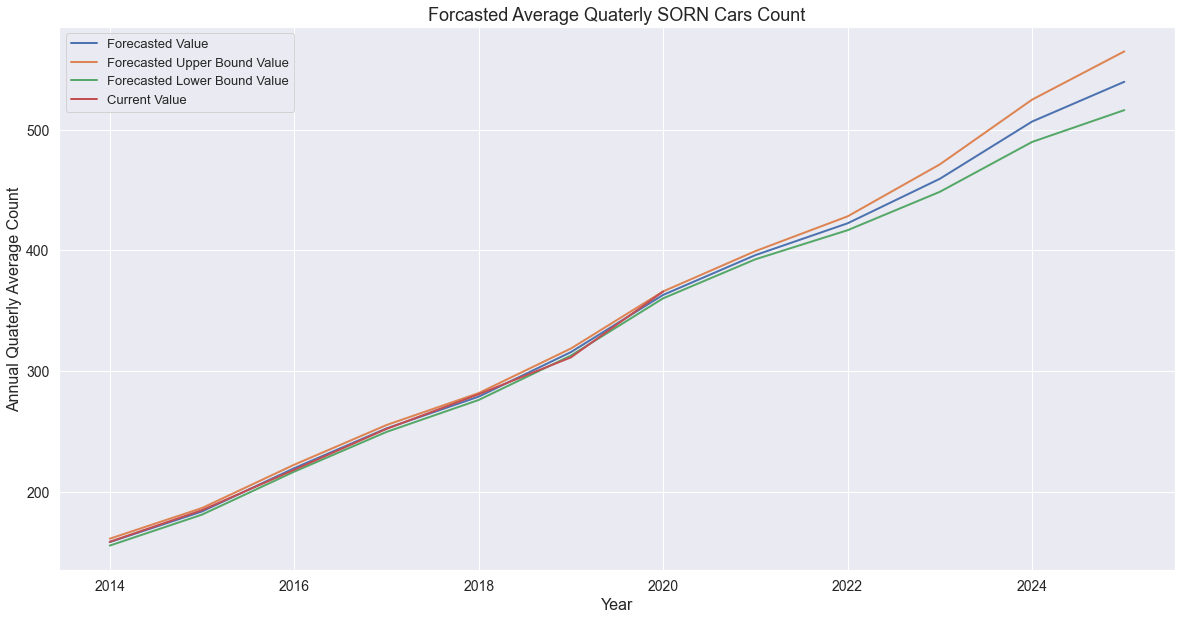

In [168]:
plt.figure(figsize=(20, 10))
sns.lineplot(x='year', y='yhat', data=forecasted, linewidth=2)
sns.lineplot(x='year', y='yhat_upper', data=forecasted, linewidth=2)
sns.lineplot(x='year', y='yhat_lower', data=forecasted, linewidth=2)
sns.lineplot(x=df['year'], y=df['4_others_mean'].tolist(), linewidth=2)

plt.title("Forcasted Average Quaterly SORN Cars Count", fontsize=18)
plt.legend(["Forecasted Value", "Forecasted Upper Bound Value", "Forecasted Lower Bound Value", "Current Value"], fontsize=13)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Annual Quaterly Average Count", fontsize=16)
plt.show()

# Average Annual Licenced Vehicle count 

In [43]:
forecasted = forecast(df, 'year', '7_total_mean')

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/gurdeep/opt/anaconda3/envs/dsmp/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:n_changepoints greater than number of observations. Using 4.
/Users/gurdeep/opt/anaconda3/envs/dsmp/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/gurdeep/opt/anaconda3/envs/dsmp/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

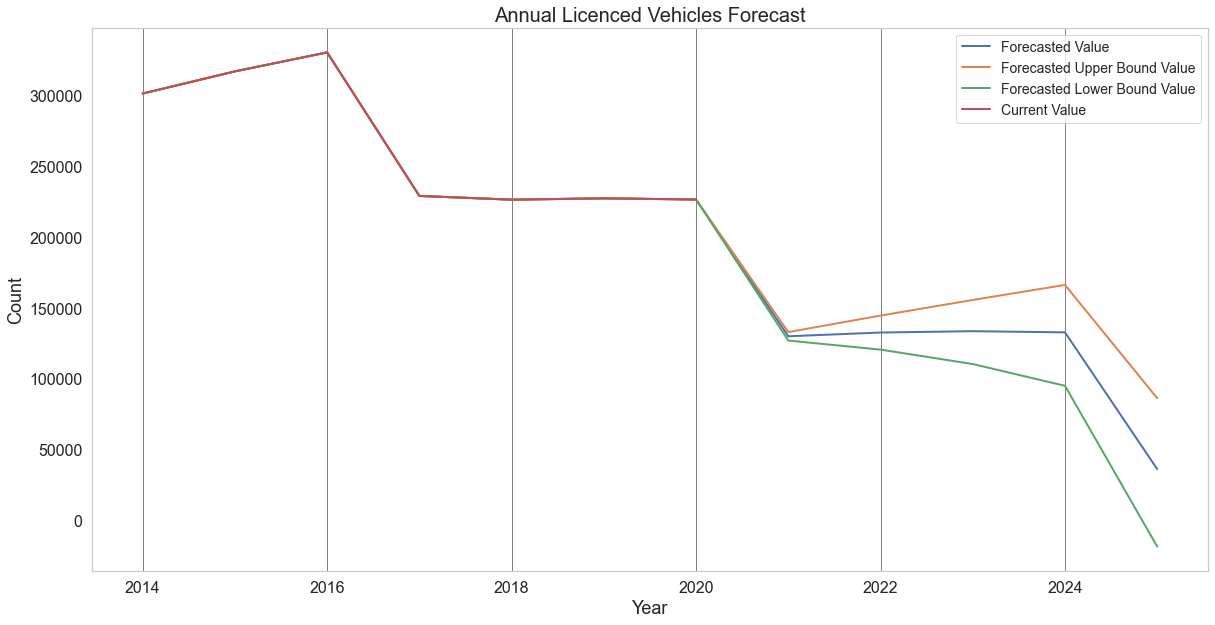

In [44]:
plt.figure(figsize=(20, 10))
sns.lineplot(x='year', y='yhat', data=forecasted, linewidth=2)
sns.lineplot(x='year', y='yhat_upper', data=forecasted, linewidth=2)
sns.lineplot(x='year', y='yhat_lower', data=forecasted, linewidth=2)
sns.lineplot(x=df['year'], y=df['7_total_mean'].tolist(), linewidth=2)

plt.title("Annual Licenced Vehicles Forecast", fontsize=20)
plt.legend(["Forecasted Value", "Forecasted Upper Bound Value", "Forecasted Lower Bound Value", "Current Value"], fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Year", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.grid(False, axis='y')
mpl.rcParams['grid.color'] = 'grey'
plt.show()

In [454]:
data = forecasted[['year', 'yhat']].merge(df[['year', '7_total_mean']], on='year', how='left')
data['y'] = data['7_total_mean'].fillna(data['yhat'])
data['y_next'] = data['y'].shift(-1)
data['y_diff'] = (data['y_next'] - data['y'])
data['y_chng'] = data['y_diff']/data['y']*100

print("Average change in licenced vehicles per year from 2014 to 2020:", np.round(data[data['year'].between(2014, 2020)]['y_diff'].mean(), 2), "per year")
print("Average change in licenced vehicles per year from 2014 to 2020:", np.round(data[data['year'].between(2014, 2020)]['y_chng'].mean(), 2), "% per year\n")

print("Average change in licenced vehicles per year from 2021 to 2025:", np.round(data[data['year'].between(2021, 2025)]['y_diff'].mean(), 2), "per year")
print("Average change in licenced vehicles per year from 2021 to 2025:", np.round(data[data['year'].between(2021, 2025)]['y_chng'].mean(), 2), "% per year\n")

print("Average change in licenced vehicles from 2020 to 2025:", np.round(data[data['year'] == 2025]['y'].iloc[0] - data[data['year'] == 2020]['y'].iloc[0], 2), "ug/m3")
print("Average change in licenced vehicles from 2020 to 2025:", np.round((data[data['year'] == 2025]['y'].iloc[0] - data[data['year'] == 2020]['y'].iloc[0])/data[data['year'] == 2020]['y'].iloc[0]*100, 2), "%")

Average change in licenced vehicles per year from 2014 to 2020: -24515.77 per year
Average change in licenced vehicles per year from 2014 to 2020: -9.29 % per year

Average change in licenced vehicles per year from 2021 to 2025: -18252.93 per year
Average change in licenced vehicles per year from 2021 to 2025: -12.66 % per year

Average change in licenced vehicles from 2020 to 2025: -190614.42 ug/m3
Average change in licenced vehicles from 2020 to 2025: -84.05 %


# Quarterly Forecasts

In [14]:
df = pd.read_csv('/Users/gurdeep/Documents/tb2/DSMP/data/quarterly_vehicle_count.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   year_quarter          31 non-null     object
 1   sorn_vehicle_count    31 non-null     int64 
 2   plugin_vehicle_count  31 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 872.0+ bytes


,year_quarter,sorn_vehicle_count,plugin_vehicle_count
0,2014 Q1,19408,128
1,2014 Q2,18095,142
2,2014 Q3,18527,170
3,2014 Q4,20145,210
4,2015 Q1,20506,259


In [15]:
df['date'] = pd.PeriodIndex(df['year_quarter'].apply(lambda x: "-".join(x.split(" "))), freq='Q').to_timestamp()
df['date'].agg(['min', 'max'])

min   2014-01-01
max   2021-07-01
Name: date, dtype: datetime64[ns]

## Quarterly SORN Vehicle Forecast

In [16]:
def forecast(df, date_col, target_col, periods=5):
    train_data=df.copy()[[date_col, target_col]].rename(columns={date_col:'ds',target_col:'y'})
    dates_str = [f"{year}-Q{q}" for q in range(1, 5) for year in range(train_data['ds'].min().year, train_data['ds'].max().year+periods+1)]
    dates = pd.PeriodIndex(dates_str, freq='Q').to_timestamp().sort_values()
    model = Prophet()
    model.fit(train_data)
    pred = model.predict(pd.DataFrame({'ds':dates}))
    pred['year_quarter'] = pred['ds'].dt.year.astype(str) + "-Q" + pred['ds'].dt.quarter.astype(str)
    return pred

forecasted = forecast(df, 'date', 'sorn_vehicle_count', 5)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/gurdeep/opt/anaconda3/envs/dsmp/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -47.2975
Iteration  1. Log joint probability =    29.9075. Improved by 77.205.
Iteration  2. Log joint probability =    67.4389. Improved by 37.5314.
Iteration  3. Log joint probability =    82.0945. Improved by 14.6556.
Iteration  4. Log joint probability =    82.1352. Improved by 0.0407017.
Iteration  5. Log joint probability =    82.1406. Improved by 0.00541381.
Iteration  6. Log joint probability =    82.2113. Improved by 0.0707227.
Iteration  7. Log joint probability =    82.2334. Improved by 0.022112.
Iteration  8. Log joint probability =      82.32. Improved by 0.0865682.
Iteration  9. Log joint probability =    82.4038. Improved by 0.0838029.
Iteration 10. Log joint probability =    82.4652. Improved by 0.061426.
Iteration 11. Log joint probability =    82.5744. Improved by 0.109243.
Iteration 12. Log joint probability =    83.7075. Improved by 1.13303.
Iteration 13. Log joint probability =    83.7411. Improved by 0.0335914.
Iteration 14. Log jo

/Users/gurdeep/opt/anaconda3/envs/dsmp/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/gurdeep/opt/anaconda3/envs/dsmp/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [17]:
sns.set(style='whitegrid')

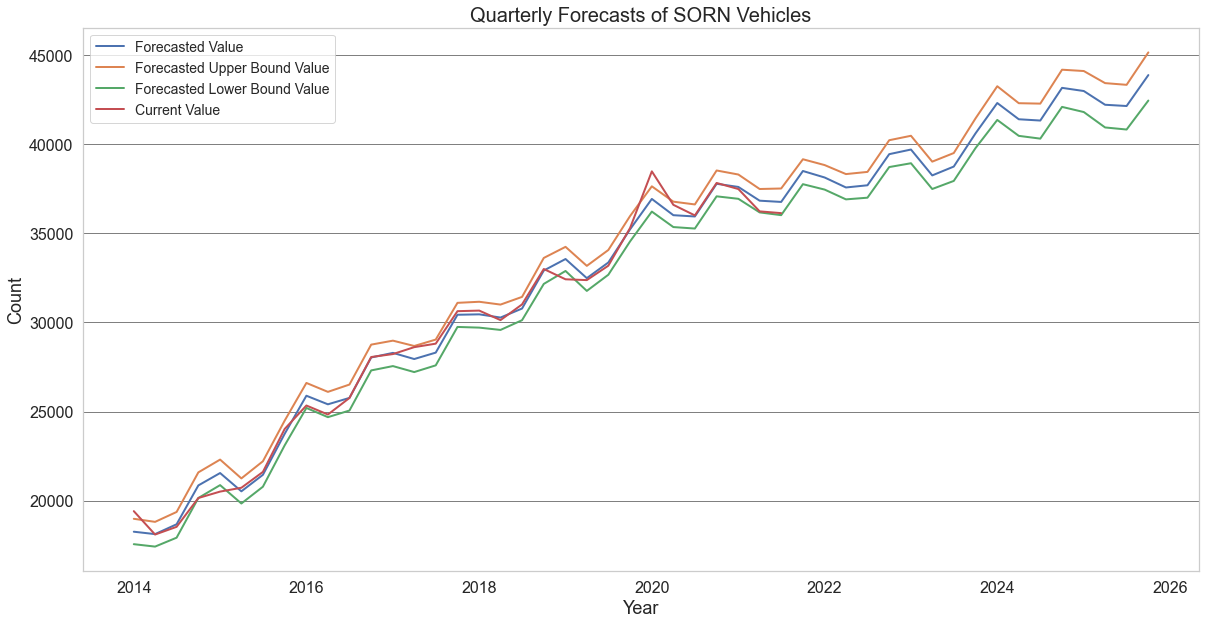

In [20]:
plt.figure(figsize=(20, 10))
# sns.lineplot(x='ds', y='yhat', data=forecasted, linewidth=2)
# sns.lineplot(x='ds', y='yhat_upper', data=forecasted, linewidth=2)
# sns.lineplot(x='ds', y='yhat_lower', data=forecasted, linewidth=2)
# sns.lineplot(x='date', y='sorn_vehicle_count', data=df, linewidth=2)

sns.lineplot(x='ds', y='yhat', data=forecasted[forecasted['ds'].between('2014-01-01', '2025-12-31')], linewidth=2)
sns.lineplot(x='ds', y='yhat_upper', data=forecasted[forecasted['ds'].between('2014-01-01', '2025-12-31')], linewidth=2)
sns.lineplot(x='ds', y='yhat_lower', data=forecasted[forecasted['ds'].between('2014-01-01', '2025-12-31')], linewidth=2)
sns.lineplot(x='date', y='sorn_vehicle_count', data=df[df['date'].between('2014-01-01', '2025-12-31')], linewidth=2)

plt.title("Quarterly Forecasts of SORN Vehicles", fontsize=20)
plt.legend(["Forecasted Value", 
            "Forecasted Upper Bound Value", 
            "Forecasted Lower Bound Value", 
            "Current Value"], 
           fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Year", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.grid(False, axis='x')
mpl.rcParams['grid.color'] = 'grey'
plt.show()

In [471]:
data = pd.concat([forecasted[['ds', 'yhat']], df[['date', 'sorn_vehicle_count']]], axis=1)
data['y'] = data['sorn_vehicle_count'].fillna(data['yhat'])
data['y_next'] = data['y'].shift(-1)
data['y_diff'] = (data['y_next'] - data['y'])
data['y_chng'] = data['y_diff']/data['y']*100

print("Average change in licenced vehicles per quarter from 2014 to 2020:", np.round(data[data['ds'].between('2014-01-01', '2020-12-31')]['y_diff'].mean(), 2), "per quarter")
print("Average change in licenced vehicles per quarter from 2014 to 2020:", np.round(data[data['ds'].between('2014-01-01', '2020-12-31')]['y_chng'].mean(), 2), "% per year\n")

print("Average change in licenced vehicles per quarter from 2021 to 2025:", np.round(data[data['ds'].between('2020-01-01', '2025-12-31')]['y_diff'].mean(), 2), "per quarter")
print("Average change in licenced vehicles per quarter from 2021 to 2025:", np.round(data[data['ds'].between('2020-01-01', '2025-12-31')]['y_chng'].mean(), 2), "% per year\n")

print("Average change in licenced vehicles from 2020 and 2025:", np.round(data[data['ds'].dt.year == 2025]['y'].mean() - data[data['ds'].dt.year == 2020]['y'].mean(), 2), "")
print("Average change in licenced vehicles from 2020 and 2025:", np.round((data[data['ds'].dt.year == 2025]['y'].mean() - data[data['ds'].dt.year == 2020]['y'].mean())/data[data['ds'].dt.year == 2020]['y'].mean()*100, 2), "%")
data

Average change in licenced vehicles per quarter from 2014 to 2020: 645.79 per quarter
Average change in licenced vehicles per quarter from 2014 to 2020: 2.47 % per year

Average change in licenced vehicles per quarter from 2021 to 2025: 210.0 per quarter
Average change in licenced vehicles per quarter from 2021 to 2025: 0.56 % per year

Average change in licenced vehicles from 2020 and 2025: 5581.39 
Average change in licenced vehicles from 2020 and 2025: 14.99 %


,ds,yhat,date,sorn_vehicle_count,y,y_next,y_diff,y_chng
0,2014-01-01,18253.292373,2014-01-01,19408.0,19408.000000,18095.000000,-1313.000000,-6.765251
1,2014-04-01,18118.397452,2014-04-01,18095.0,18095.000000,18527.000000,432.000000,2.387400
2,2014-07-01,18670.892771,2014-07-01,18527.0,18527.000000,20145.000000,1618.000000,8.733200
3,2014-10-01,20852.018476,2014-10-01,20145.0,20145.000000,20506.000000,361.000000,1.792008
4,2015-01-01,21547.165285,2015-01-01,20506.0,20506.000000,20721.000000,215.000000,1.048474
5,2015-04-01,20520.709196,2015-04-01,20721.0,20721.000000,21610.000000,889.000000,4.290333
6,2015-07-01,21447.626829,2015-07-01,21610.0,21610.000000,24020.000000,2410.000000,11.152244
7,2015-10-01,23746.560318,2015-10-01,24020.0,24020.000000,25338.000000,1318.000000,5.487094
8,2016-01-01,25886.412005,2016-01-01,25338.0,25338.000000,24832.000000,-506.000000,-1.997001
9,2016-04-01,25404.954947,2016-04-01,24832.0,24832.000000,25760.000000,928.000000,3.737113


## Quarterly forecasts of PlugIn Vehicles

In [21]:
forecasted = forecast(df, 'date', 'plugin_vehicle_count', 6)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/gurdeep/opt/anaconda3/envs/dsmp/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -48.0742
Iteration  1. Log joint probability =    20.2661. Improved by 68.3404.
Iteration  2. Log joint probability =     42.435. Improved by 22.1688.
Iteration  3. Log joint probability =    54.6654. Improved by 12.2304.
Iteration  4. Log joint probability =    55.7306. Improved by 1.06522.
Iteration  5. Log joint probability =    55.8305. Improved by 0.0998875.
Iteration  6. Log joint probability =     55.839. Improved by 0.00851902.
Iteration  7. Log joint probability =    55.8506. Improved by 0.0115574.
Iteration  8. Log joint probability =    55.8605. Improved by 0.00991616.
Iteration  9. Log joint probability =    55.8943. Improved by 0.0338208.
Iteration 10. Log joint probability =    55.9082. Improved by 0.0138679.
Iteration 11. Log joint probability =    55.9839. Improved by 0.0756645.
Iteration 12. Log joint probability =    56.0645. Improved by 0.0806081.
Iteration 13. Log joint probability =    56.0877. Improved by 0.0232298.
Iteration 14. L

/Users/gurdeep/opt/anaconda3/envs/dsmp/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/gurdeep/opt/anaconda3/envs/dsmp/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


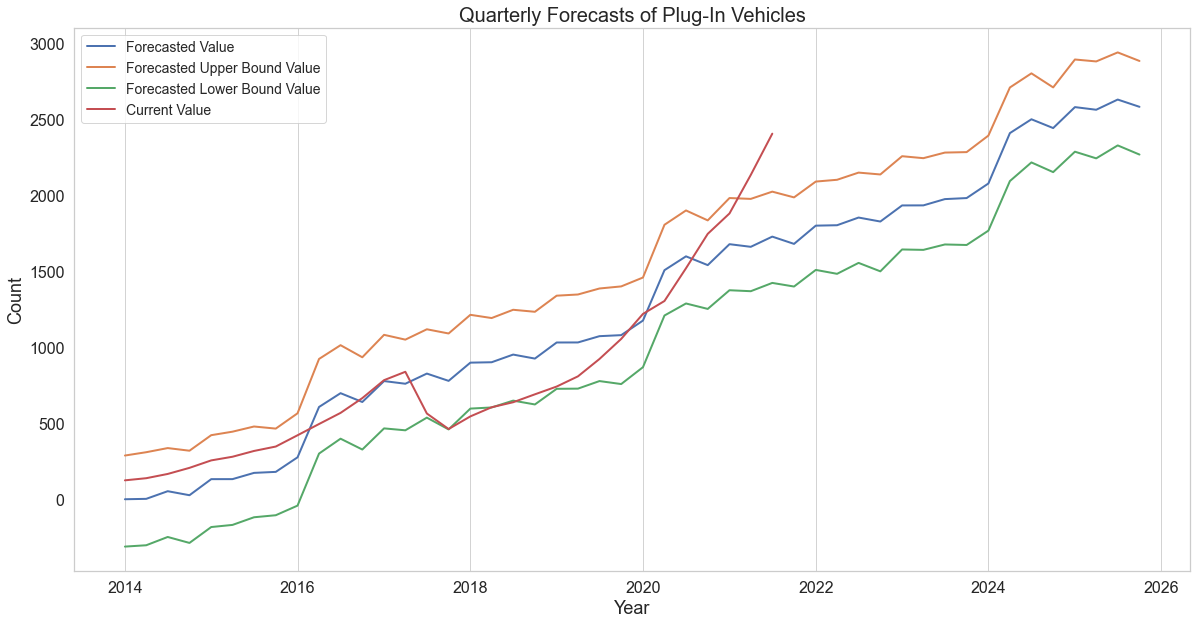

In [25]:
plt.figure(figsize=(20, 10))
# sns.lineplot(x='ds', y='yhat', data=forecasted, linewidth=2)
# sns.lineplot(x='ds', y='yhat_upper', data=forecasted, linewidth=2)
# sns.lineplot(x='ds', y='yhat_lower', data=forecasted, linewidth=2)
# sns.lineplot(x='date', y='plugin_vehicle_count', data=df, linewidth=2)

sns.lineplot(x='ds', y='yhat', data=forecasted[forecasted['ds'].between('2014-01-01', '2025-12-31')], linewidth=2)
sns.lineplot(x='ds', y='yhat_upper', data=forecasted[forecasted['ds'].between('2014-01-01', '2025-12-31')], linewidth=2)
sns.lineplot(x='ds', y='yhat_lower', data=forecasted[forecasted['ds'].between('2014-01-01', '2025-12-31')], linewidth=2)
sns.lineplot(x='date', y='plugin_vehicle_count', data=df[df['date'].between('2014-01-01', '2025-12-31')], linewidth=2)

plt.title("Quarterly Forecasts of Plug-In Vehicles", fontsize=20)
plt.legend(["Forecasted Value", 
            "Forecasted Upper Bound Value", 
            "Forecasted Lower Bound Value", 
            "Current Value"], 
           fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Year", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.grid(False, axis='y')
mpl.rcParams['grid.color'] = 'grey'
plt.show()

In [474]:
data = pd.concat([forecasted[['ds', 'yhat']], df[['date', 'plugin_vehicle_count']]], axis=1)
data['y'] = data['plugin_vehicle_count'].fillna(data['yhat'])
data['y_next'] = data['y'].shift(-1)
data['y_diff'] = (data['y_next'] - data['y'])
data['y_chng'] = data['y_diff']/data['y']*100

print("Average change in licenced vehicles per quarter from 2014 to 2020:", np.round(data[data['ds'].between('2014-01-01', '2020-12-31')]['y_diff'].mean(), 2), "per quarter")
print("Average change in licenced vehicles per quarter from 2014 to 2020:", np.round(data[data['ds'].between('2014-01-01', '2020-12-31')]['y_chng'].mean(), 2), "% per year\n")

print("Average change in licenced vehicles per quarter from 2021 to 2025:", np.round(data[data['ds'].between('2020-01-01', '2025-12-31')]['y_diff'].mean(), 2), "per quarter")
print("Average change in licenced vehicles per quarter from 2021 to 2025:", np.round(data[data['ds'].between('2020-01-01', '2025-12-31')]['y_chng'].mean(), 2), "% per year\n")

print("Average change in licenced vehicles from 2020 and 2025:", np.round(data[data['ds'].dt.year == 2025]['y'].mean() - data[data['ds'].dt.year == 2020]['y'].mean(), 2), "")
print("Average change in licenced vehicles from 2020 and 2025:", np.round((data[data['ds'].dt.year == 2025]['y'].mean() - data[data['ds'].dt.year == 2020]['y'].mean())/data[data['ds'].dt.year == 2020]['y'].mean()*100, 2), "%")
data

Average change in licenced vehicles per quarter from 2014 to 2020: 62.61 per quarter
Average change in licenced vehicles per quarter from 2014 to 2020: 10.79 % per year

Average change in licenced vehicles per quarter from 2021 to 2025: 61.67 per quarter
Average change in licenced vehicles per quarter from 2021 to 2025: 3.82 % per year

Average change in licenced vehicles from 2020 and 2025: 1139.27 
Average change in licenced vehicles from 2020 and 2025: 78.64 %


,ds,yhat,date,plugin_vehicle_count,y,y_next,y_diff,y_chng
0,2014-01-01,3.836060,2014-01-01,128.0,128.000000,142.000000,14.000000,10.937500
1,2014-04-01,6.393456,2014-04-01,142.0,142.000000,170.000000,28.000000,19.718310
2,2014-07-01,56.662750,2014-07-01,170.0,170.000000,210.000000,40.000000,23.529412
3,2014-10-01,30.267132,2014-10-01,210.0,210.000000,259.000000,49.000000,23.333333
4,2015-01-01,135.817901,2015-01-01,259.0,259.000000,283.000000,24.000000,9.266409
5,2015-04-01,135.971328,2015-04-01,283.0,283.000000,321.000000,38.000000,13.427562
6,2015-07-01,176.968524,2015-07-01,321.0,321.000000,350.000000,29.000000,9.034268
7,2015-10-01,183.593648,2015-10-01,350.0,350.000000,424.000000,74.000000,21.142857
8,2016-01-01,279.100501,2016-01-01,424.0,424.000000,498.000000,74.000000,17.452830
9,2016-04-01,609.897194,2016-04-01,498.0,498.000000,571.000000,73.000000,14.658635
